In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import re
import seaborn as sns

from datetime import datetime
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from pyclustering.cluster.kmedoids import kmedoids
from tqdm import tqdm

In [2]:
def split_headlines(df):

    patterns = ['buy_now', 'shop_now', 'limited_offer', 'add_cart',
                'use_code', 'free_shipping', 'today_only', 'free_delivery',
                'extra_discount', 'voucher_code', 'last_chance', 'up_to',
                '%_off']

    for i in patterns:
        pattern_split = i.split('_')    
        pattern = re.compile(rf"\b{pattern_split[0]}.*\b{pattern_split[1]}", 
                             re.I)
        df[i] = df.apply(lambda x: 1 if pattern.search(x.headline) else 0, 
                         axis=1)

    return df

In [3]:
df = pd.read_csv('fb_19_20_2.csv')
df = split_headlines(df)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_clustering = df[['brand_name', 'channel', 'cost', 'buy_now', 'shop_now', 'limited_offer', 'add_cart', 'use_code', 'free_shipping', 'today_only',
             'free_delivery', 'extra_discount', 'voucher_code', 'last_chance', 'up_to', '%_off']]
df_clustering
df_clustering_dummies = pd.get_dummies(df_clustering, columns=['brand_name', 'channel'])
df_clustering_dummies
standard_scaler = RobustScaler()
X_ns = standard_scaler.fit_transform(df_clustering_dummies)
df_X_ns = pd.DataFrame(X_ns, columns = df_clustering_dummies.columns)
X_airbnb_small_ns = PCA(n_components=2, random_state=1337).fit_transform(X_ns)


In [4]:
df_clustering_dummies.columns

Index(['cost', 'buy_now', 'shop_now', 'limited_offer', 'add_cart', 'use_code',
       'free_shipping', 'today_only', 'free_delivery', 'extra_discount',
       'voucher_code', 'last_chance', 'up_to', '%_off', 'brand_name_Enfa',
       'brand_name_Lactum', 'brand_name_Sustagen', 'channel_Lazada',
       'channel_Shopee'],
      dtype='object')

In [5]:
def cluster_range(X, k_start, k_stop, actual=None):
    """
    Return cluster labels, internal, and/or external validation values
    
    Accepts the design matrix `X`, clustering object `clusterer`, initial and
    final values to step through, `k_start` and `k_stop` and optionally 
    `actual` labels then computes for the internal validation values and, if
    actual values are given, external validation values, for every `k`. A
    random state of `1337` is used for all instances where it can be defined.
    
    Parameters
    ----------
    X : np.array 
        Design matrix
    clusterer : kmedoids clustering object
        Clustering object
    k_start : int
        Inital value to step through
    k_stop : int
        Final value to step through
    actual : list of int
        Actual data labels
    
    Returns
    -------
    res : dict
        Dictionary containing internal and external validation values
    """
    # Initialize results container
    ys = []
    inertias = []
    chs = []
    shs = []
    dbs = []
    centroids = []
    res = {}
    
    # Initialize progress bar
    pb = tqdm(total=k_stop-k_start+1)
    
    for k in range(k_start, k_stop+1):
        # Set description of progress bar
        pb.set_description("Running k: {}".format(k))
        print("Number of Cluster: {}".format(k))
        # Clone clusterer

        clusterer_k = KMedoids(n_clusters=k).fit(X)

        # Set parameters of clusterer, fit and predict

        y = clusterer_k.predict(X)

        # Add internal validation values
        ys.append(y)
        inertias.append(clusterer_k.inertia_)
        print("Inertia: {:.2f} | {}".format(inertias[-1], datetime.now()))
        chs.append(calinski_harabasz_score(X, y))
        print("CH-score: {:.2f} | {}".format(chs[-1], datetime.now()))
        centroids.append(clusterer_k.cluster_centers_)
        shs.append(silhouette_score(X, y))
        print("SH-score: {:.2f} | {}".format(shs[-1], datetime.now()))
        dbs.append(davies_bouldin_score(X, y))
        print("DB-score: {:.2f} | {}\n".format(dbs[-1], datetime.now()))


        pb.update(1)

    # Record results
    res['ys'] = ys
    res['inertias'] = inertias
    res['chs'] = chs
    res['centroids'] = centroids
    res['dbs'] = dbs
    res['shs'] = shs

    return res

In [6]:
res1 = cluster_range(X_ns, 2, 6)

Running k: 2:   0%|                                                                              | 0/5 [00:00<?, ?it/s]

Number of Cluster: 2
Inertia: 22931.88 | 2021-06-18 13:05:50.762727
CH-score: 6037.14 | 2021-06-18 13:05:50.770705


Running k: 3:  20%|██████████████                                                        | 1/5 [00:16<01:07, 16.75s/it]

SH-score: 0.58 | 2021-06-18 13:05:53.448544
DB-score: 0.93 | 2021-06-18 13:05:53.455525

Number of Cluster: 3
Inertia: 20341.88 | 2021-06-18 13:06:03.913581
CH-score: 3651.87 | 2021-06-18 13:06:03.918568


Running k: 4:  40%|████████████████████████████                                          | 2/5 [00:29<00:46, 15.62s/it]

SH-score: 0.20 | 2021-06-18 13:06:06.423840
DB-score: 1.54 | 2021-06-18 13:06:06.428828

Number of Cluster: 4
Inertia: 18800.85 | 2021-06-18 13:06:13.889874
CH-score: 2728.23 | 2021-06-18 13:06:13.892867


Running k: 5:  60%|██████████████████████████████████████████                            | 3/5 [00:39<00:27, 13.89s/it]

SH-score: 0.15 | 2021-06-18 13:06:16.287487
DB-score: 1.72 | 2021-06-18 13:06:16.293471

Number of Cluster: 5
Inertia: 17515.00 | 2021-06-18 13:06:28.853853
CH-score: 3953.86 | 2021-06-18 13:06:28.858840


Running k: 6:  80%|████████████████████████████████████████████████████████              | 4/5 [00:54<00:14, 14.24s/it]

SH-score: 0.19 | 2021-06-18 13:06:31.334254
DB-score: 1.53 | 2021-06-18 13:06:31.342196

Number of Cluster: 6
Inertia: 16933.23 | 2021-06-18 13:06:41.900956
CH-score: 3302.18 | 2021-06-18 13:06:41.904973


Running k: 6: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.89s/it]

SH-score: 0.17 | 2021-06-18 13:06:44.402267
DB-score: 1.54 | 2021-06-18 13:06:44.408251



In [7]:
def plot_internal(inertias, chs, scs, dbs):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, dbs, fmt='-go', label='DB')
    ax2.plot(ks, scs, '-ko', label='SH')
    ax2.set_ylabel('Davies Bouldin/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

In [8]:
def plot_clusters(X, ys, state, d1=0, d2=1):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=300, sharex=True, sharey=True, 
                           figsize=(8, 6), 
                           gridspec_kw=dict(wspace=0.075, hspace=0.15))
    for k,y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(X[:, d1], X[:, d2], c=y, s=1, alpha=0.8)
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
            
        else:
            ax[1][k%k_mid].scatter(X[:, d1], X[:, d2], c=y, s=1, alpha=0.8)
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    
    # Set figure title
    fig.text(s=state.title(), x=0.075, y=0.5, horizontalalignment='center', 
             verticalalignment='center', fontsize=16, rotation=90)
    
    return fig, ax

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


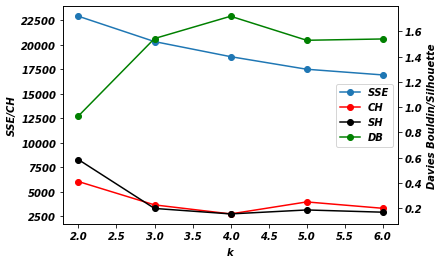

In [9]:
plot_internal(res1['inertias'], res1['chs'], res1['shs'],
              res1['dbs'])

In [10]:
import matplotlib.transforms as transforms
# 


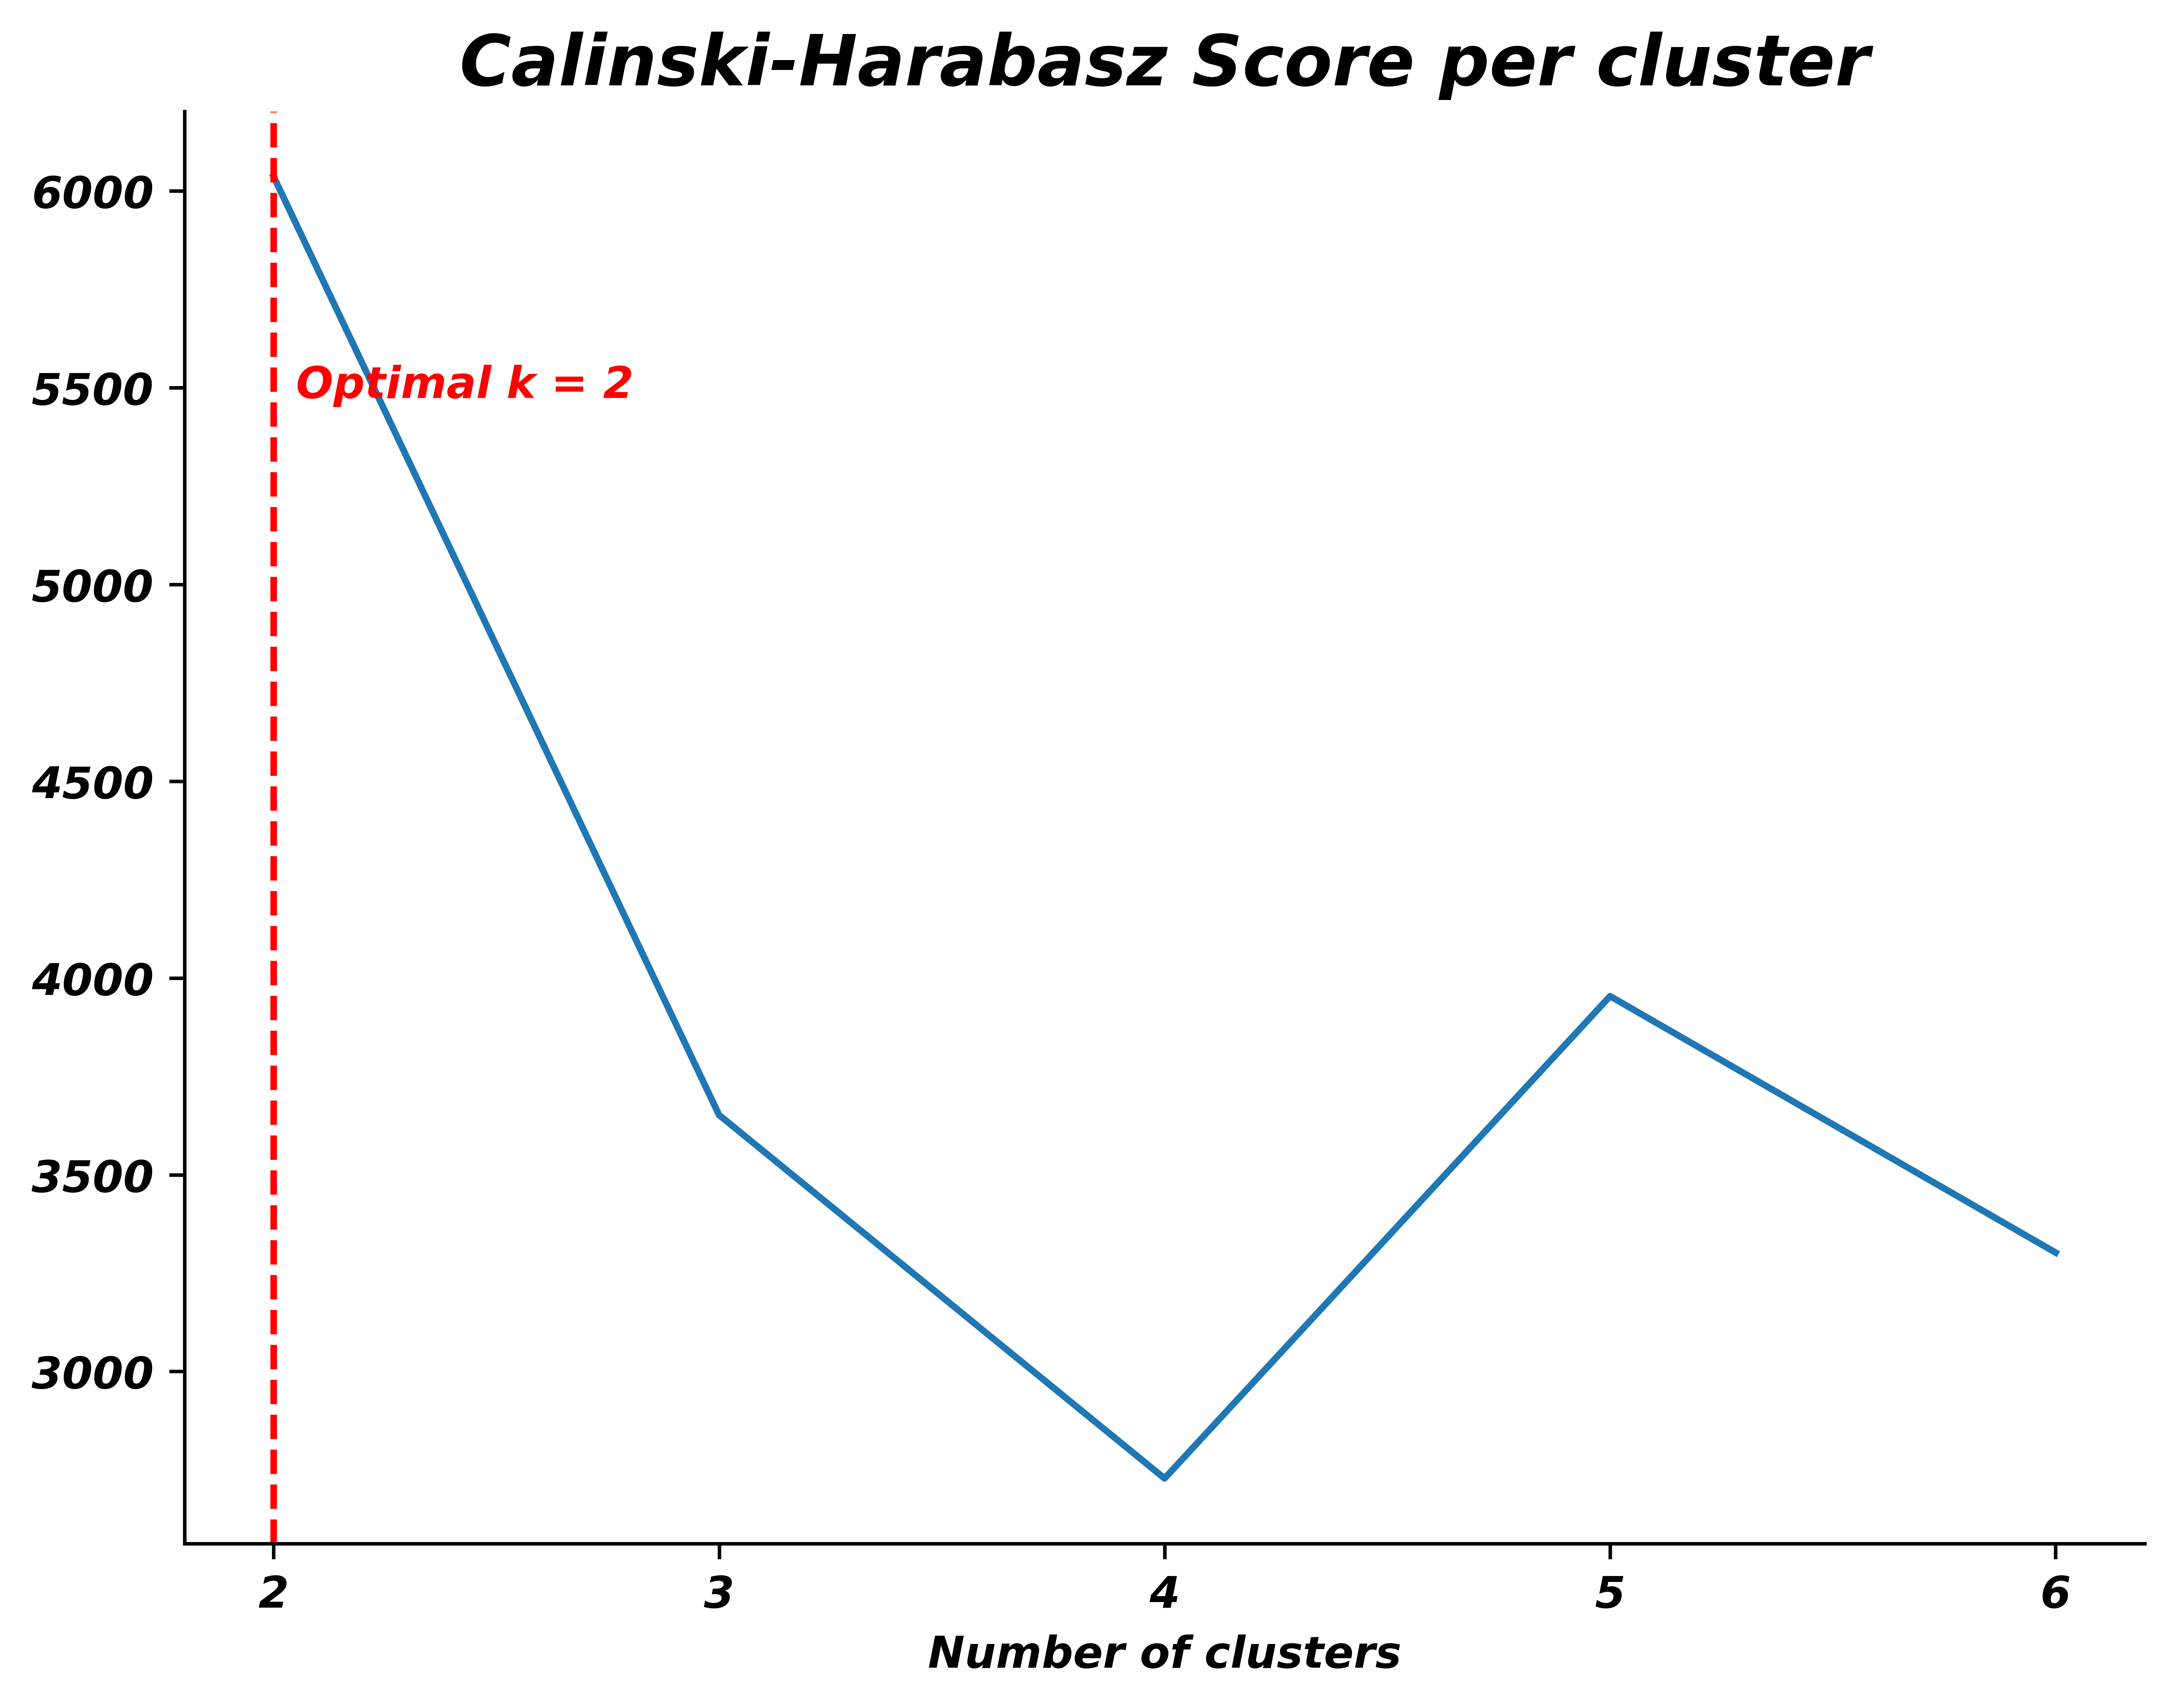

In [11]:
fig = plt.figure(figsize=(8, 6), dpi=800)
ax = fig.add_subplot(111)
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.plot(range(2, 7), res1['chs'])
ax.axvline(x=2, color='red', linestyle='--')
ax.set_title('Calinski-Harabasz Score per cluster', fontsize=16, weight='bold')
ax.set_xlabel('Number of clusters')
ax.set_xticks(range(2, 7))
ax.text(2 + 0.05, 0.8, "Optimal k = 2", color='red', transform=trans)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

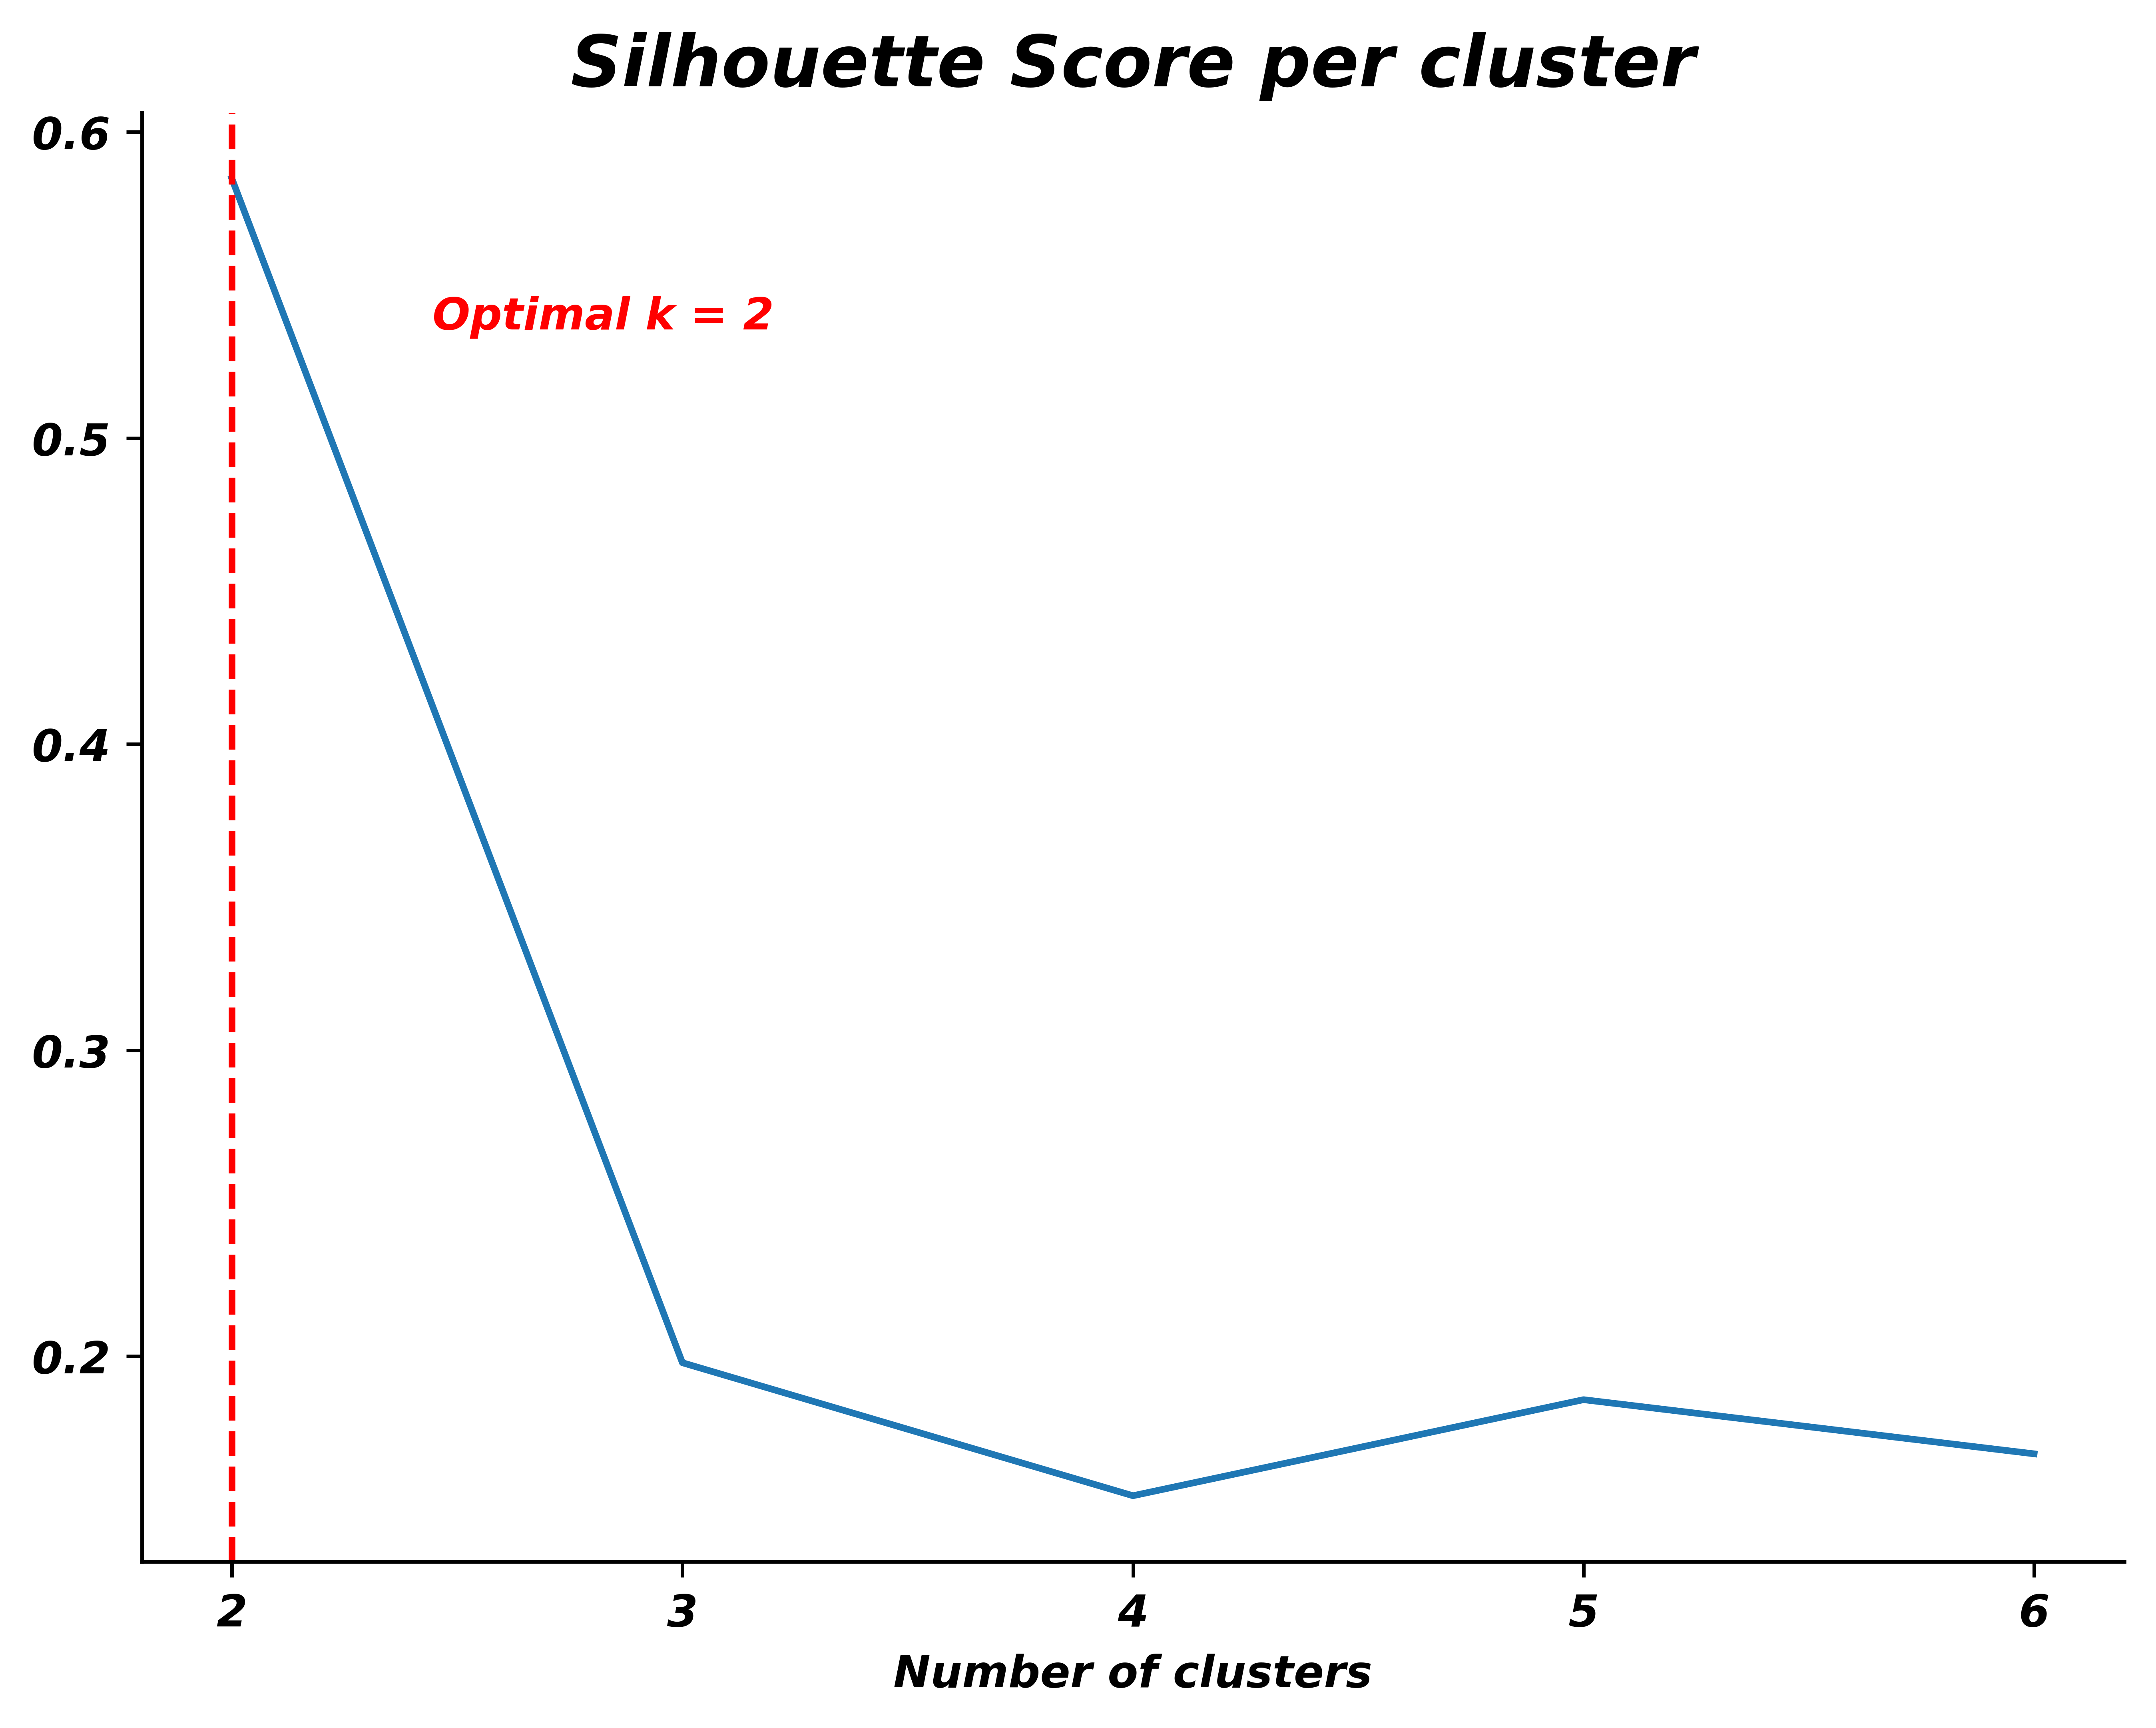

In [12]:
fig = plt.figure(figsize=(8, 6), dpi=800)
ax = fig.add_subplot(111)
ax.plot(range(2, 7), res1['shs'])
ax.axvline(x=2, color='red', linestyle='--')
ax.set_title('Silhouette Score per cluster', fontsize=16, weight='bold')
ax.set_xlabel('Number of clusters')
ax.text(2 + 0.05, 0.8, "Optimal k = 2", color='red', transform=trans)
ax.set_xticks(range(2, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

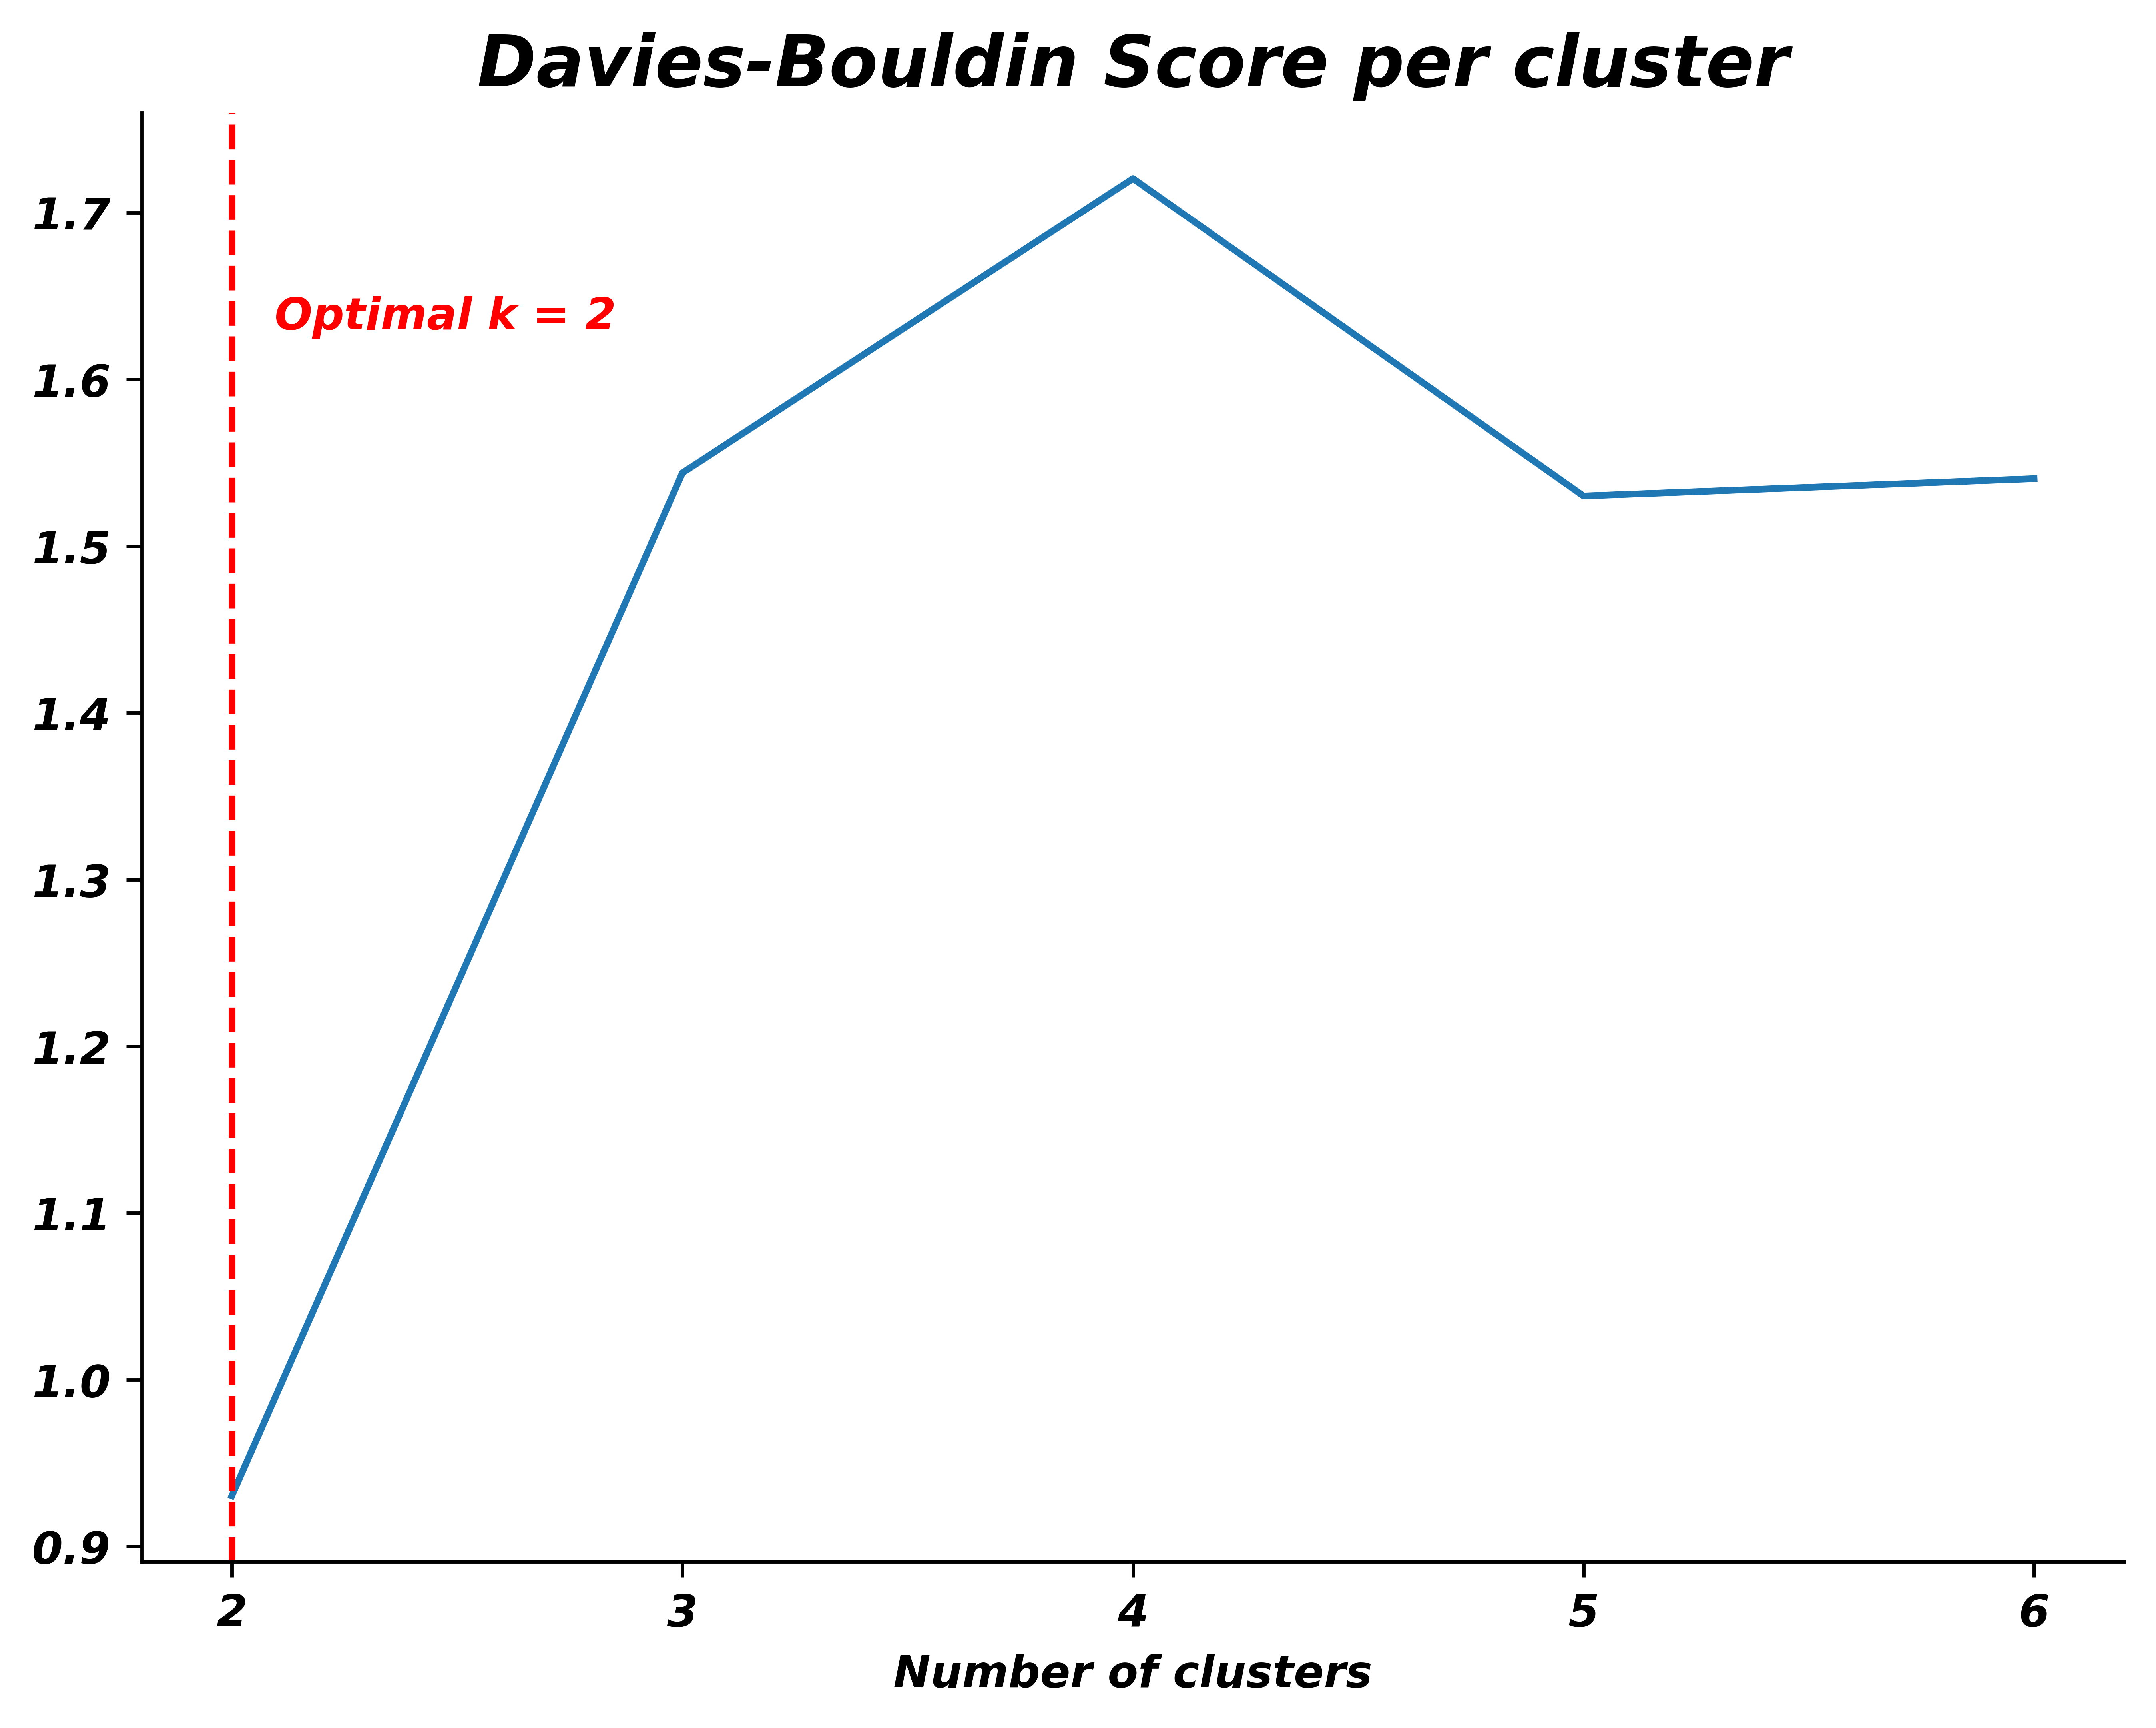

In [13]:
fig = plt.figure(figsize=(8, 6), dpi=800)
ax = fig.add_subplot(111)
ax.plot(range(2, 7), res1['dbs'])
ax.axvline(x=2, color='red', linestyle='--')
ax.set_title('Davies-Bouldin Score per cluster', fontsize=16, weight='bold')
ax.set_xlabel('Number of clusters')
ax.text(1.7, 0.8, "Optimal k = 2", color='red', transform=trans)
ax.set_xticks(range(2, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

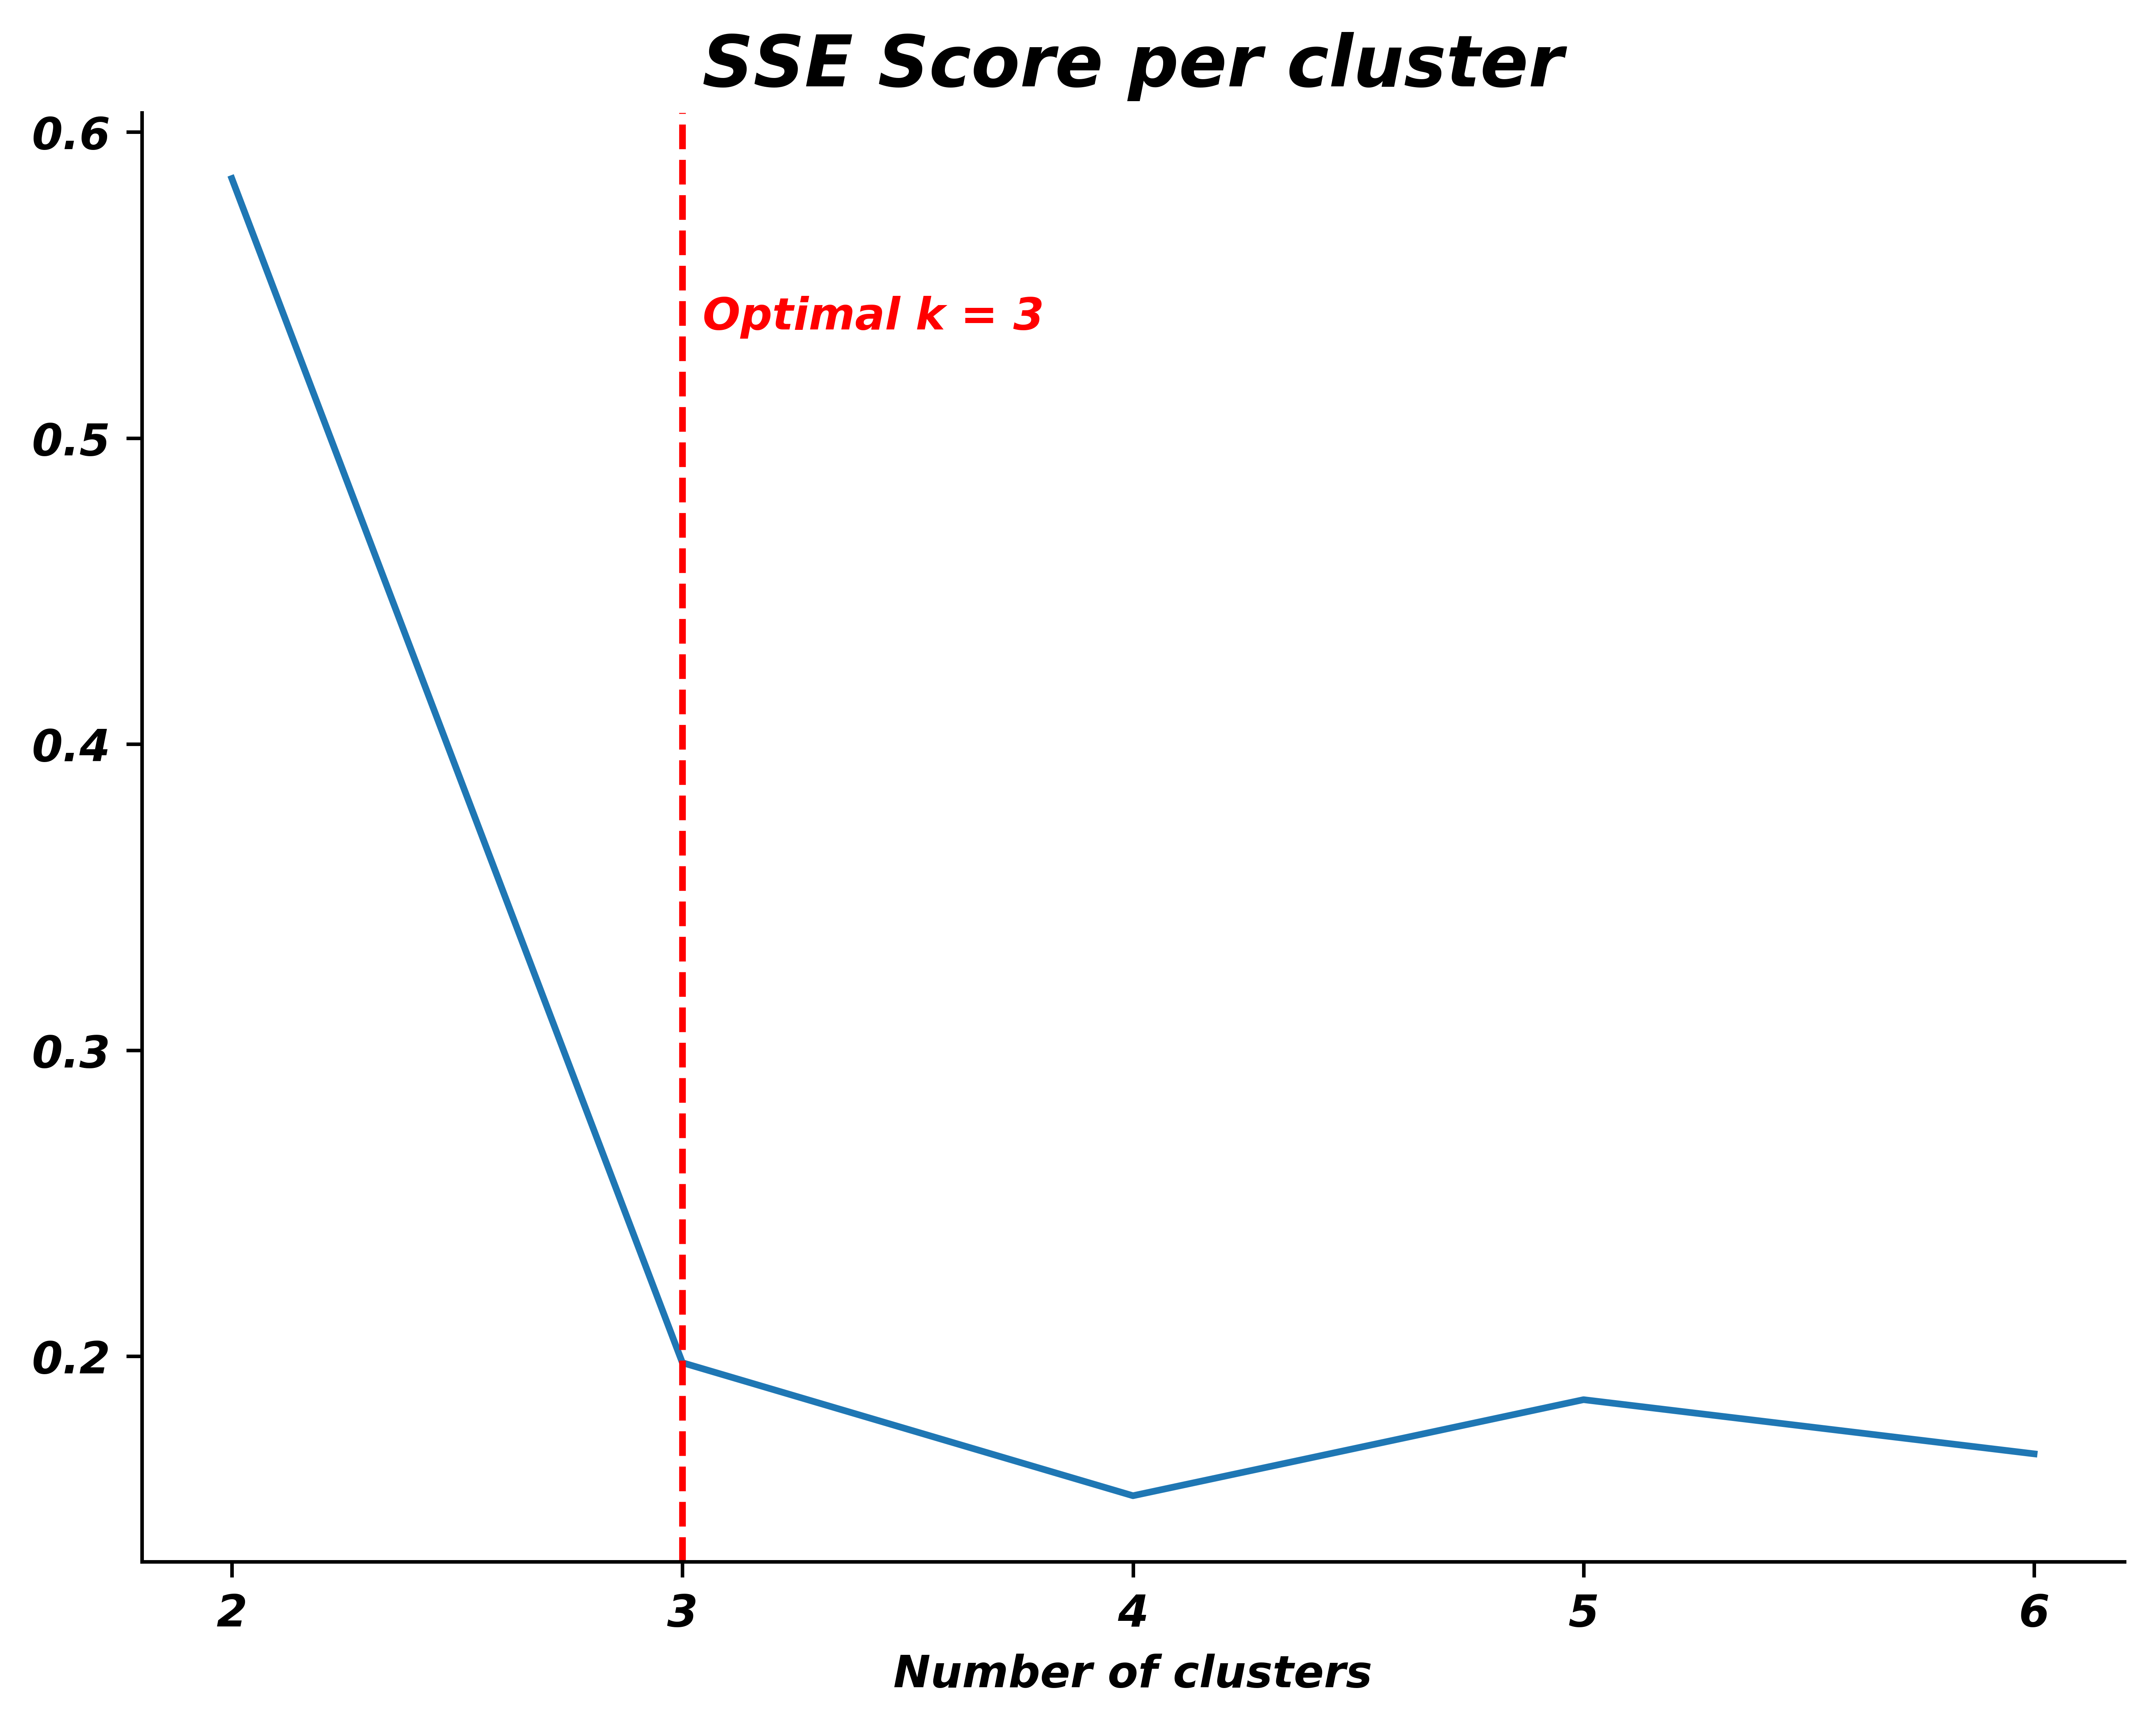

In [14]:
fig = plt.figure(figsize=(8, 6), dpi=800)
ax = fig.add_subplot(111)
ax.plot(range(2, 7), res1['shs'])
ax.axvline(x=3, color='red', linestyle='--')
ax.set_title('SSE Score per cluster', fontsize=16, weight='bold')
ax.set_xlabel('Number of clusters')
ax.text(2 + 0.65, 0.8, "Optimal k = 3", color='red', transform=trans)
ax.set_xticks(range(2, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [10]:
clusterer_k = KMedoids(n_clusters=2).fit(X_ns)

In [11]:
df_cluster = df_clustering_dummies.copy()
df_viz = df.copy()
df_viz['cluster'] = clusterer_k.labels_.tolist()
df_cluster['cluster'] = clusterer_k.labels_.tolist()

In [12]:
df_viz_0 = df_viz[df_viz['cluster'] == 0]
df_viz_1 = df_viz[df_viz['cluster'] == 1]


In [13]:
df_cluster['cluster'].value_counts()

0    9848
1    1363
Name: cluster, dtype: int64

In [14]:
df_X_ns_cluster1 = df_cluster[df_cluster['cluster'] == 1]
df_X_ns_cluster1

,cost,buy_now,shop_now,limited_offer,add_cart,use_code,free_shipping,today_only,free_delivery,extra_discount,voucher_code,last_chance,up_to,%_off,brand_name_Enfa,brand_name_Lactum,brand_name_Sustagen,channel_Lazada,channel_Shopee,cluster
19,233.600006,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
20,144.259995,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
21,213.869995,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
22,431.559998,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
23,847.739990,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9626,128.839996,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1
9725,190.630005,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1
9814,108.519997,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1
9823,108.940002,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1


In [15]:
df_X_ns_cluster0 = df_cluster[df_cluster['cluster'] == 0]
df_X_ns_cluster0

,cost,buy_now,shop_now,limited_offer,add_cart,use_code,free_shipping,today_only,free_delivery,extra_discount,voucher_code,last_chance,up_to,%_off,brand_name_Enfa,brand_name_Lactum,brand_name_Sustagen,channel_Lazada,channel_Shopee,cluster
0,24.180000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,23.700001,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,23.910000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,18.559999,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,21.250000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11206,15.890000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0
11207,8.910000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0
11208,0.280000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0
11209,7.990000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0


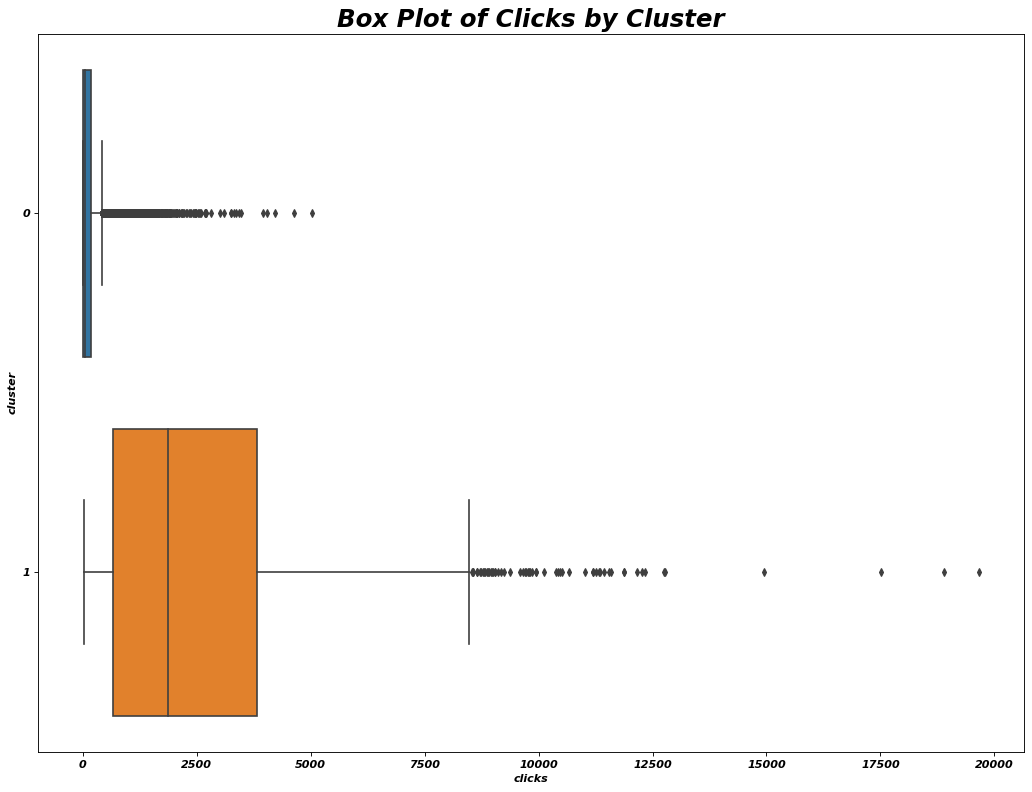

In [21]:
# get data
df0 = df.copy()
df0['cluster'] = clusterer_k.labels_.tolist()
# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='clicks', data=df0, notch=False, orient='h')

# labels
plt.title('Box Plot of Clicks by Cluster', fontsize=22)
plt.tight_layout()
plt.show()

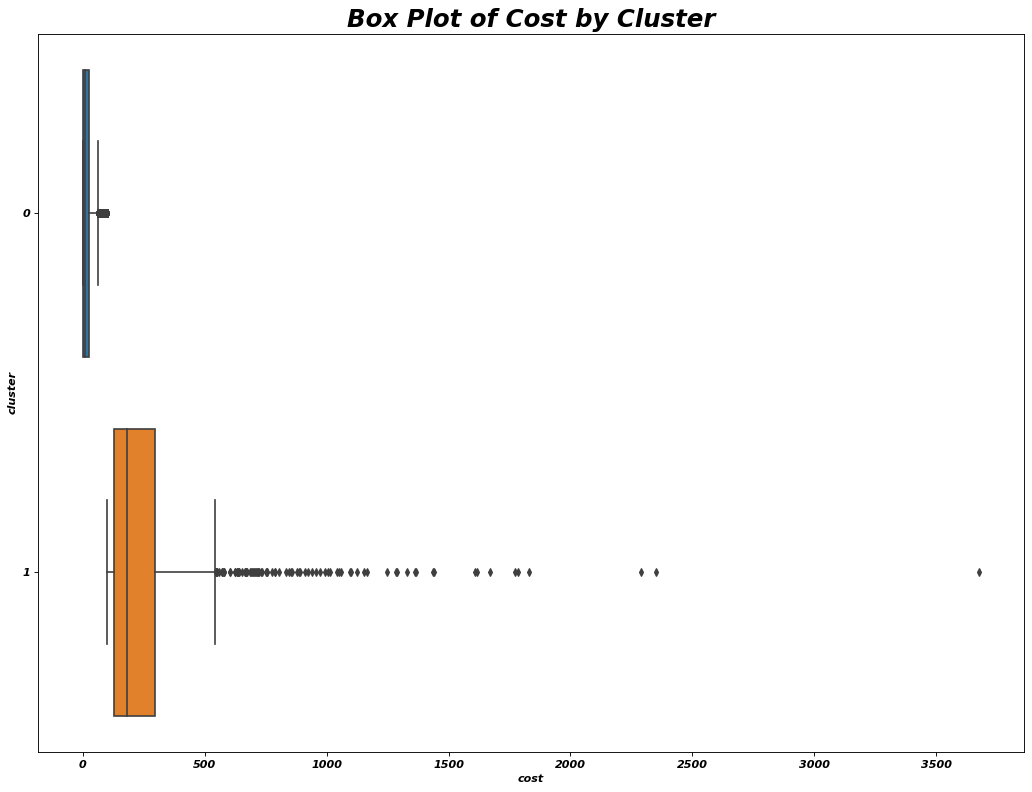

In [24]:
# get data
df0 = df.copy()
df0['cluster'] = clusterer_k.labels_.tolist()
# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='cost', data=df0, notch=False, orient='h')

# labels
plt.title('Box Plot of Cost by Cluster', fontsize=22)
plt.tight_layout()
plt.show()

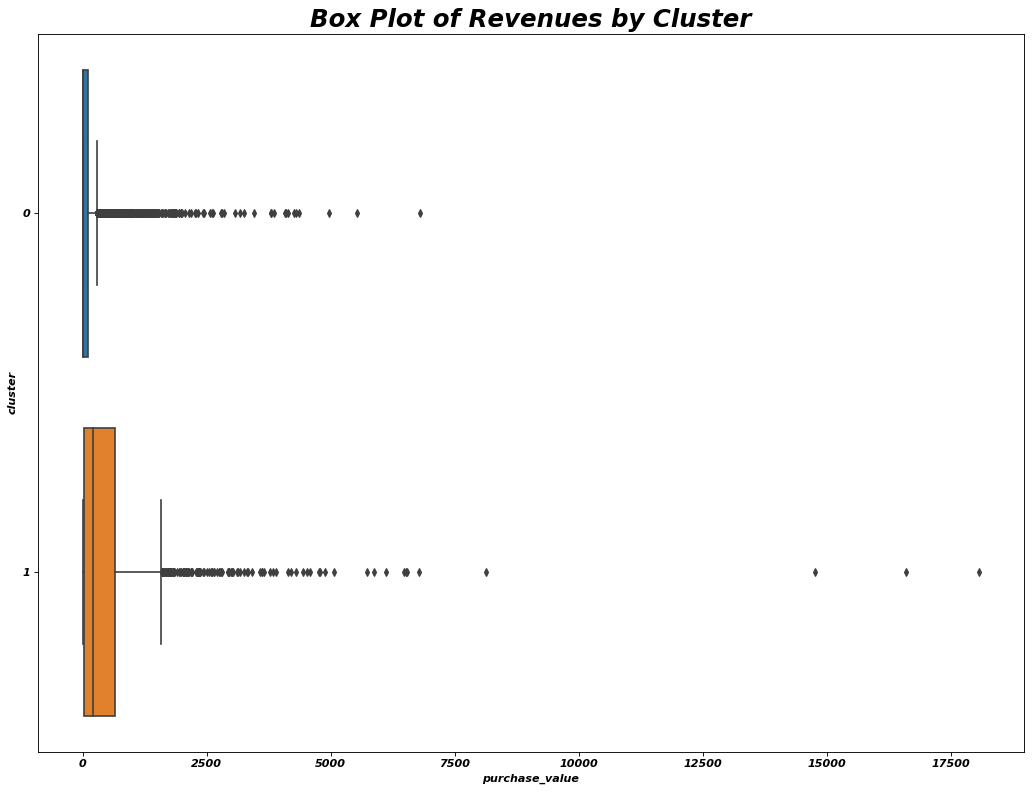

In [23]:
# get data
df0 = df.copy()
df0['cluster'] = clusterer_k.labels_.tolist()
# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='purchase_value', data=df0, notch=False, orient='h')

# labels
plt.title('Box Plot of Revenues by Cluster', fontsize=22)
plt.tight_layout()
plt.show()

# DITO MO LAGAY

# cluster cluster 0

In [85]:
df_0 = df_X_ns_cluster0.copy()
df_0 = df_0.drop('cluster', axis=1)

In [86]:
res2 = cluster_range(df_0, 2, 6)



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Running k: 2:   0%|                                                                              | 0/5 [00:00<?, ?it/s]

Number of Cluster: 2
Inertia: 86654.66 | 2021-06-13 22:43:33.995861
CH-score: 26866.15 | 2021-06-13 22:43:34.149482




Running k: 2:  20%|██████████████                                                        | 1/5 [00:17<01:10, 17.59s/it]

Running k: 3:  20%|██████████████                                                        | 1/5 [00:17<01:10, 17.59s/it]

SH-score: 0.70 | 2021-06-13 22:43:36.251829
DB-score: 0.52 | 2021-06-13 22:43:36.261803

Number of Cluster: 3
Inertia: 60621.66 | 2021-06-13 22:43:48.067174
CH-score: 34688.15 | 2021-06-13 22:43:48.074147




Running k: 3:  40%|████████████████████████████                                          | 2/5 [00:31<00:49, 16.49s/it]

Running k: 4:  40%|████████████████████████████                                          | 2/5 [00:31<00:49, 16.49s/it]

SH-score: 0.63 | 2021-06-13 22:43:50.175530
DB-score: 0.52 | 2021-06-13 22:43:50.187496

Number of Cluster: 4
Inertia: 47530.55 | 2021-06-13 22:44:02.849639
CH-score: 42479.86 | 2021-06-13 22:44:02.857618




Running k: 4:  60%|██████████████████████████████████████████                            | 3/5 [00:46<00:31, 15.97s/it]

Running k: 5:  60%|██████████████████████████████████████████                            | 3/5 [00:46<00:31, 15.97s/it]

SH-score: 0.58 | 2021-06-13 22:44:04.853281
DB-score: 0.54 | 2021-06-13 22:44:04.863256

Number of Cluster: 5
Inertia: 40205.12 | 2021-06-13 22:44:20.153161
CH-score: 48258.89 | 2021-06-13 22:44:20.161139




Running k: 5:  80%|████████████████████████████████████████████████████████              | 4/5 [01:03<00:16, 16.34s/it]

Running k: 6:  80%|████████████████████████████████████████████████████████              | 4/5 [01:03<00:16, 16.34s/it]

SH-score: 0.54 | 2021-06-13 22:44:22.113918
DB-score: 0.57 | 2021-06-13 22:44:22.124889

Number of Cluster: 6
Inertia: 35527.57 | 2021-06-13 22:44:38.083218
CH-score: 51534.56 | 2021-06-13 22:44:38.090200
SH-score: 0.50 | 2021-06-13 22:44:39.861463




Running k: 6: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [01:21<00:00, 16.87s/it]

DB-score: 0.60 | 2021-06-13 22:44:40.234291



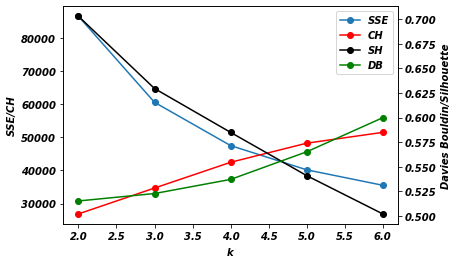

In [87]:
plot_internal(res2['inertias'], res2['chs'], res2['shs'],
              res2['dbs'])

In [88]:
clusterer_0 = KMedoids(n_clusters=4).fit(df_0)


In [101]:
df_00 = df_viz_0.copy()
df_00['cluster'] = clusterer_0.labels_.tolist()

In [102]:
df_00['cluster'].value_counts()

2    4909
0    2382
1    1544
3    1013
Name: cluster, dtype: int64

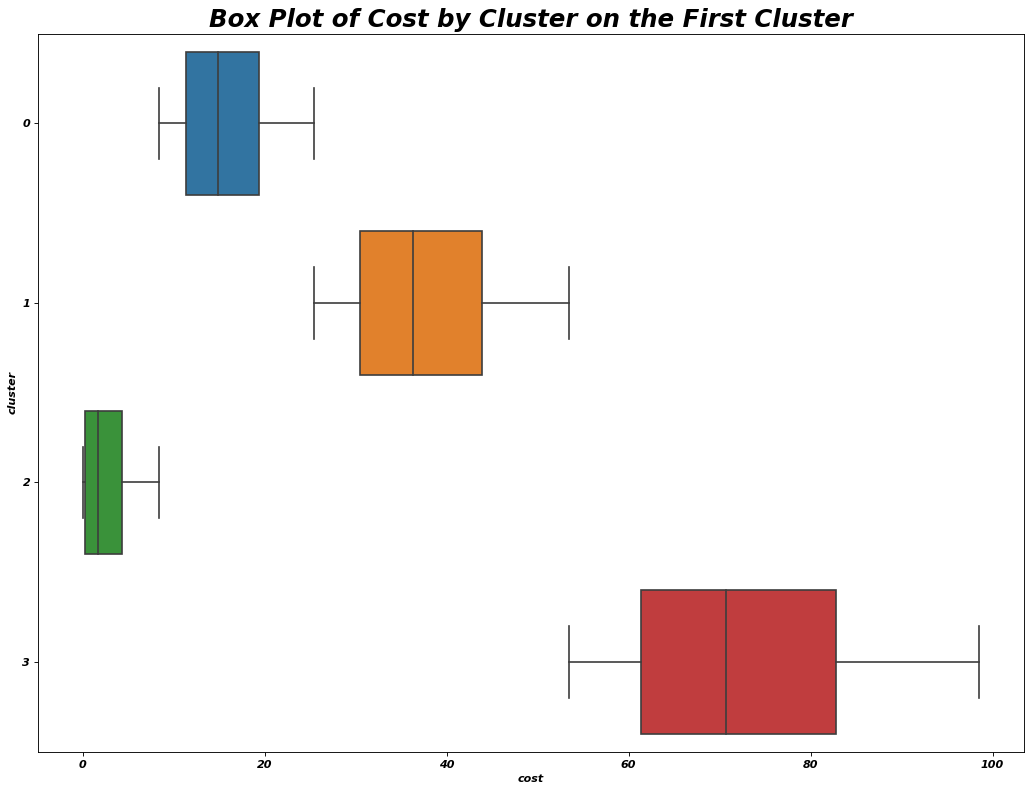

In [103]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='cost', data=df_00, notch=False, orient='h')

# labels
plt.title('Box Plot of Cost per Cluster on the First Cluster', fontsize=22)
plt.tight_layout()
plt.show()

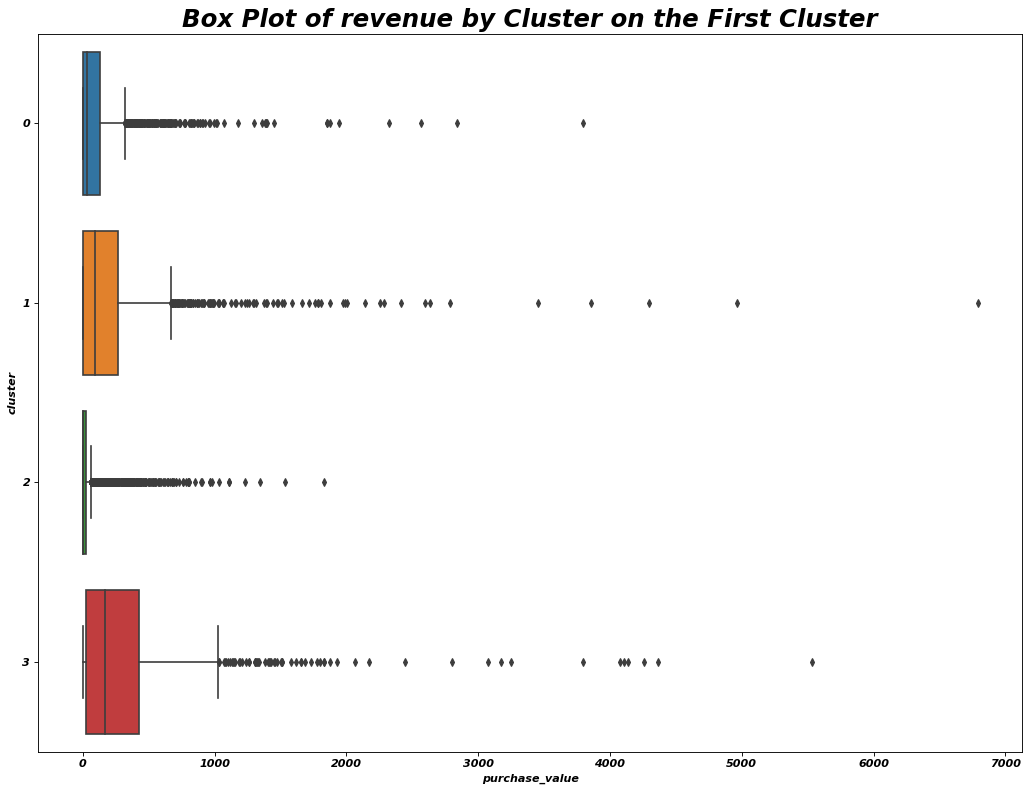

In [104]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='purchase_value', data=df_00, notch=False, orient='h')

# labels
plt.title('Box Plot of revenue by Cluster on the First Cluster', fontsize=22)
plt.tight_layout()
plt.show()

# three clusters

In [23]:
clusterer_k = KMedoids(n_clusters=3).fit(X_ns)

In [24]:
df_clustering_dummies1 = df_clustering_dummies.copy()
df_clustering_dummies1['cluster'] = clusterer_k.labels_.tolist()
df_clustering_dummies1.to_csv('df_fb_cluster.csv')

In [25]:
df_clustering_dummies1_cluster1 = df_clustering_dummies1[df_clustering_dummies1['cluster'] == 1]
df_clustering_dummies1_cluster1

,cost,buy_now,shop_now,limited_offer,add_cart,use_code,free_shipping,today_only,free_delivery,extra_discount,voucher_code,last_chance,up_to,%_off,brand_name_Enfa,brand_name_Lactum,brand_name_Sustagen,channel_Lazada,channel_Shopee,cluster
252,41.480000,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
260,16.770000,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
261,81.370003,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
262,60.110001,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
263,59.959999,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11206,15.890000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1
11207,8.910000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1
11208,0.280000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1
11209,7.990000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1


In [26]:
df_clustering_dummies1_cluster0 = df_clustering_dummies1[df_clustering_dummies1['cluster'] == 0]
df_clustering_dummies1_cluster0

,cost,buy_now,shop_now,limited_offer,add_cart,use_code,free_shipping,today_only,free_delivery,extra_discount,voucher_code,last_chance,up_to,%_off,brand_name_Enfa,brand_name_Lactum,brand_name_Sustagen,channel_Lazada,channel_Shopee,cluster
0,24.180000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,23.700001,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,23.910000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,18.559999,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,21.250000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11198,2.130000,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0
11199,2.660000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0
11200,1.390000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0
11201,2.910000,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0


In [31]:
df_desc = pd.DataFrame(columns=['Cluster 0', 'Cluster 1', 'Percent of Cluster 0', 'Percent of Cluster 1'])
df_desc.loc['mean_cost'] = [mean_0, mean_1, np.nan, np.nan]
df_desc.loc['count'] = [count_0, count_1, np.nan, np.nan]
for item in range(len(index1)):
    df_desc.loc[index1[item]] = [str(values_0[item]).split('.')[0],
                                 str(values_1[item]).split('.')[0],
                                 values_0[item]/9848,
                                 values_1[item]/1363]


In [32]:
df_desc[['Cluster 0', 'Percent of Cluster 0', 'Cluster 1', 'Percent of Cluster 1']]

,Cluster 0,Percent of Cluster 0,Cluster 1,Percent of Cluster 1
mean_cost,18.5029,NaN,18.3821,NaN
count,5541,NaN,4322,NaN
buy_now_count,1250,0.126929,1388,1.018342
shop_now_count,387,0.039297,390,0.286134
limited_offer_count,141,0.014318,0,0.000000
add_cart_count,2539,0.257819,1396,1.024211
use_code_count,13,0.001320,32,0.023478
free_shipping_count,1438,0.146019,514,0.377109
today_only_count,8,0.000812,0,0.000000
free_delivery_count,132,0.013404,0,0.000000


In [33]:
index1 = [item + '_count' for item in index]
index1

['buy_now_count',
 'shop_now_count',
 'limited_offer_count',
 'add_cart_count',
 'use_code_count',
 'free_shipping_count',
 'today_only_count',
 'free_delivery_count',
 'extra_discount_count',
 'voucher_code_count',
 'last_chance_count',
 'up_to_count',
 '%_off_count',
 'brand_name_Enfa_count',
 'brand_name_Lactum_count',
 'brand_name_Sustagen_count',
 'channel_Lazada_count',
 'channel_Shopee_count']

In [34]:
df['cluster'] = clusterer_k.labels_.tolist()

In [35]:
df[df['cluster'] == 1].columns

Index(['date', 'country', 'brand_name', 'channel', 'profile_name',
       'campaign_name', 'ad_set_name', 'ad_name', 'headline', 'cost',
       'impressions', 'clicks', 'ctr', 'ave_cpc', 'link_clicks',
       'outbound_clicks', 'view_content_actions', 'add_cart_actions',
       'add_cart_value', 'purchase_actions', 'purchase_value', 'buy_now',
       'shop_now', 'limited_offer', 'add_cart', 'use_code', 'free_shipping',
       'today_only', 'free_delivery', 'extra_discount', 'voucher_code',
       'last_chance', 'up_to', '%_off', 'cluster'],
      dtype='object')

In [36]:
df.ctr

0         0.969039
1         0.759429
2         1.390874
3         0.639205
4         0.561319
           ...    
11206     1.122334
11207     2.904700
11208    19.230768
11209     0.911546
11210     1.827243
Name: ctr, Length: 11211, dtype: float64

In [37]:
df2 = df.groupby('cluster')['impressions', 'clicks', 'ctr', 'ave_cpc', 'link_clicks',
   'outbound_clicks', 'view_content_actions', 'add_cart_actions',
   'add_cart_value', 'purchase_actions', 'purchase_value'].mean().reset_index()
df2

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cluster,impressions,clicks,ctr,ave_cpc,link_clicks,outbound_clicks,view_content_actions,add_cart_actions,add_cart_value,purchase_actions,purchase_value
0,0,18310.525898,176.346869,1.993283,0.214735,98.487277,32.447212,61.301029,10.309872,445.108809,2.064790,106.857629
1,1,18849.999537,165.385007,1.687858,0.234117,90.080287,23.463906,53.078667,10.192041,490.641536,2.245257,124.632855
2,2,320093.835312,2709.624629,1.118659,0.237146,1466.847923,389.951039,335.293027,52.305638,2111.203176,11.045994,564.409783


In [38]:
list1 = ['impressions', 'clicks', 'ctr', 'ave_cpc', 'link_clicks',
   'outbound_clicks', 'view_content_actions', 'add_cart_actions',
   'add_cart_value', 'purchase_actions', 'purchase_value']

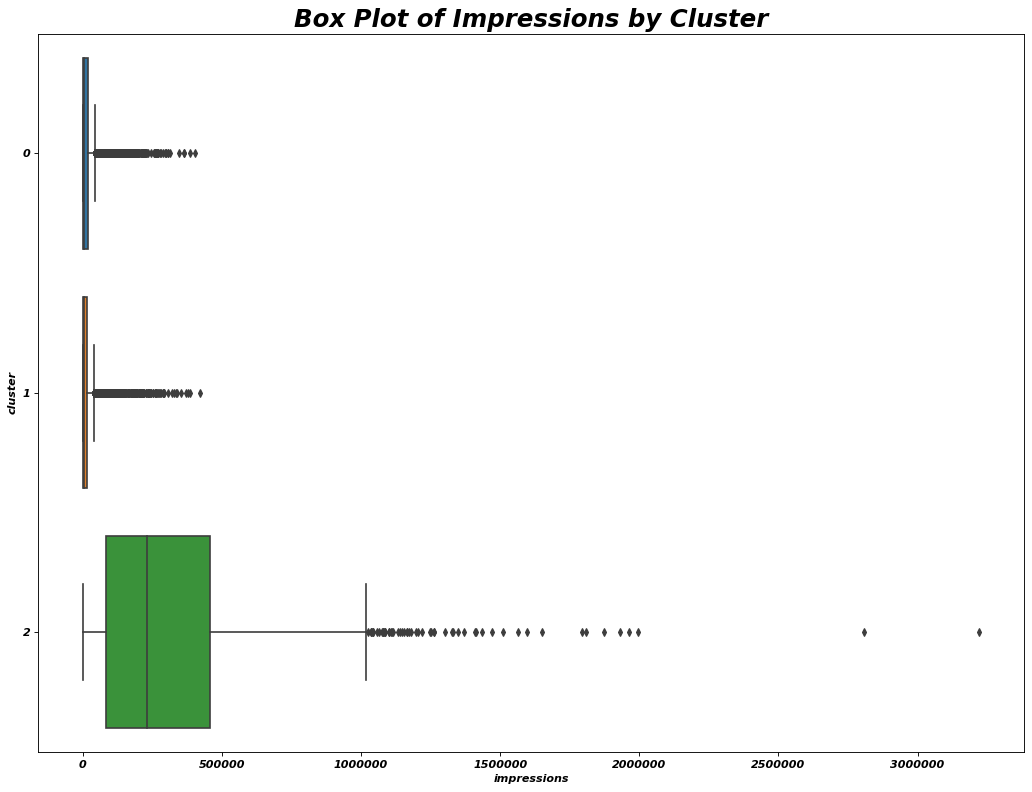

In [39]:
# get data
df0 = df.copy()

# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='impressions', data=df0, notch=False, orient='h')

# labels
plt.title('Box Plot of Impressions by Cluster', fontsize=22)
plt.tight_layout()
plt.show()

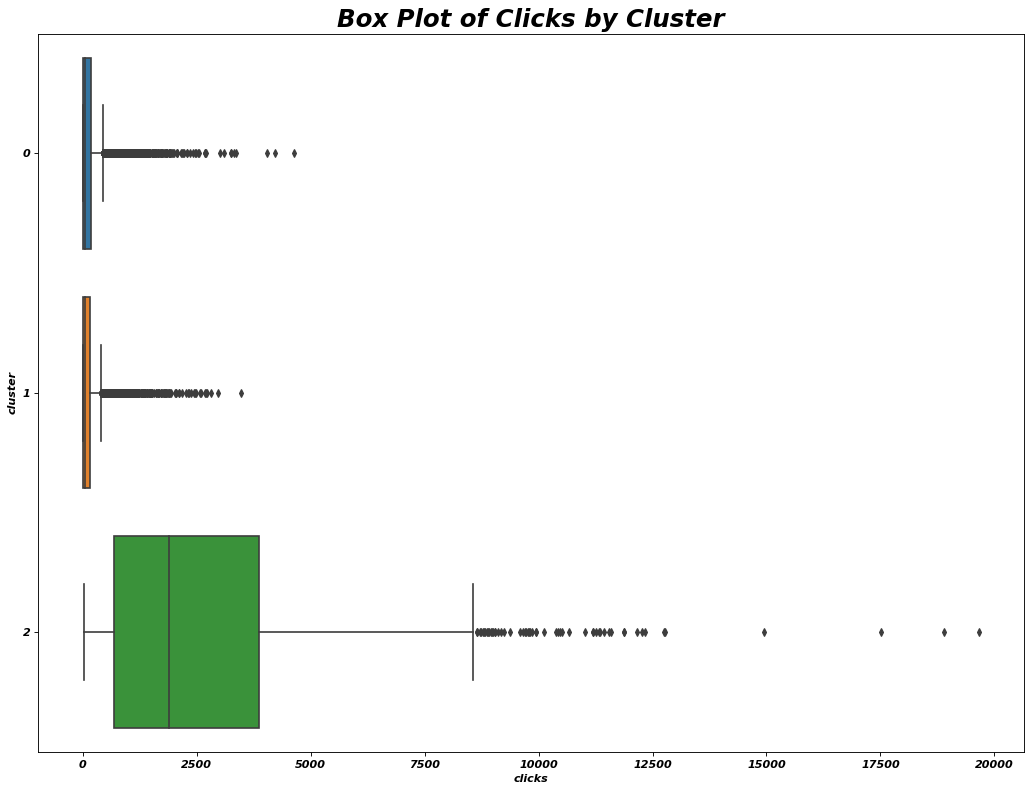

In [40]:
# get data
df0 = df.copy()

# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='clicks', data=df0, notch=False, orient='h')

# labels
plt.title('Box Plot of Clicks by Cluster', fontsize=22)
plt.tight_layout()
plt.show()

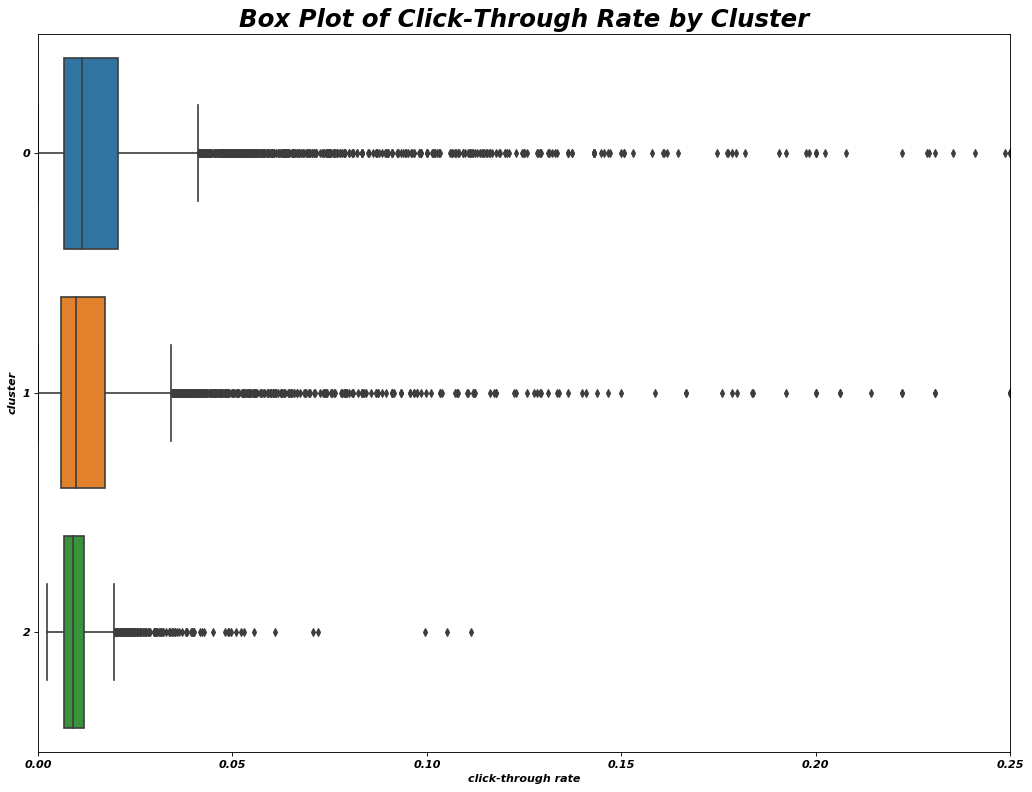

In [41]:
# get data
df0 = df.copy()
df0['click-through rate'] = df['clicks'] / df['impressions']

# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='click-through rate', data=df0, notch=False, orient='h')

# labels
plt.title('Box Plot of Click-Through Rate by Cluster', fontsize=22)
plt.xlim(0, 0.25)
plt.tight_layout()
plt.show()

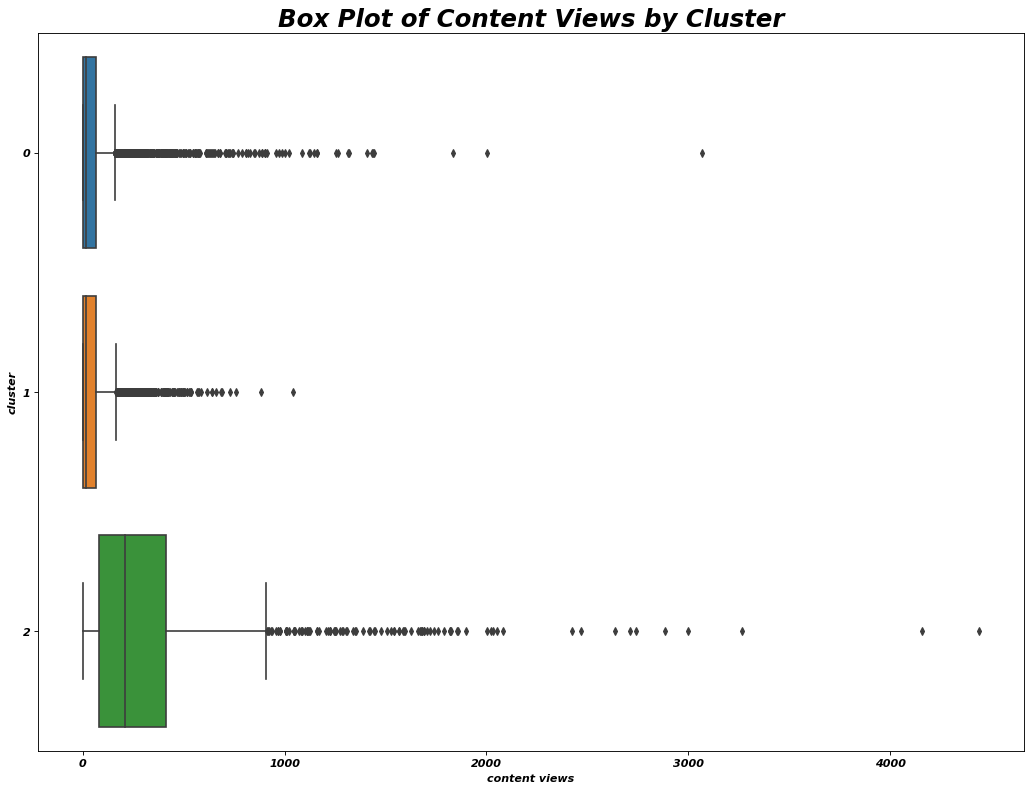

In [42]:
# get data
df0 = df.copy()

# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='view_content_actions', data=df, notch=False, orient='h')

# labels
plt.title('Box Plot of Content Views by Cluster', fontsize=22)
# plt.xlim(0, 2000000)
plt.tight_layout()
plt.xlabel('content views')
plt.show()

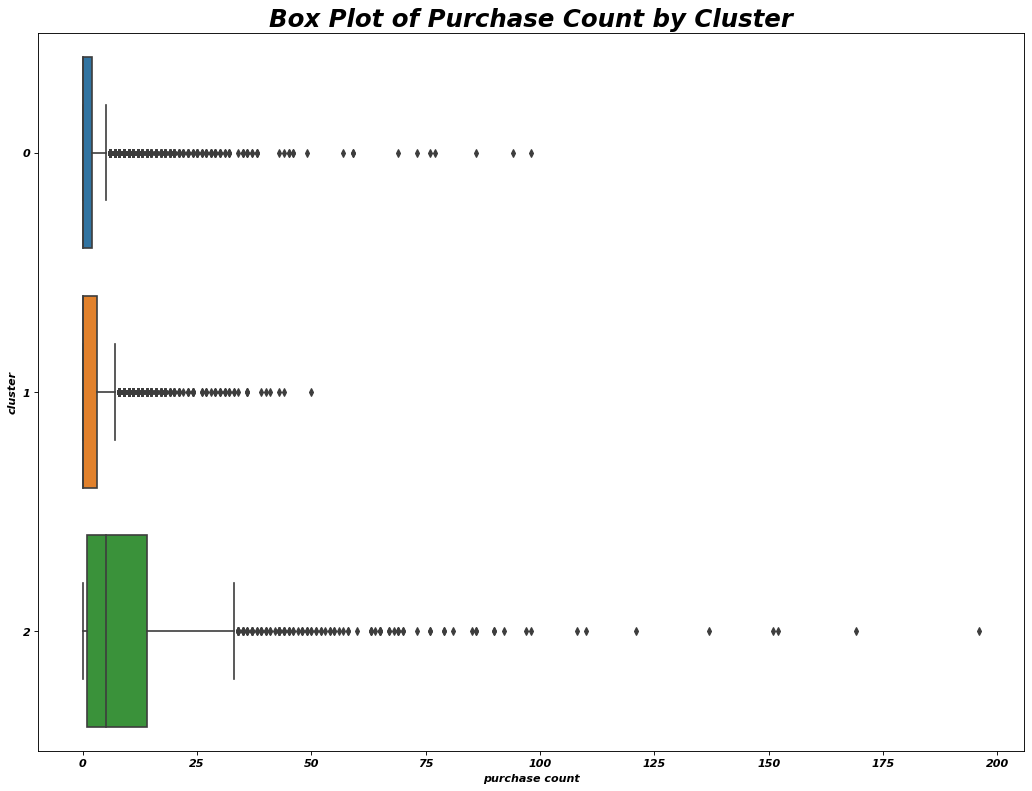

In [43]:
# get data
df0 = df.copy()

# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='purchase_actions', data=df, notch=False, orient='h')

# labels
plt.title('Box Plot of Purchase Count by Cluster', fontsize=22)
# plt.xlim(0, 2000000)
plt.tight_layout()
plt.xlabel('purchase count')
plt.show()

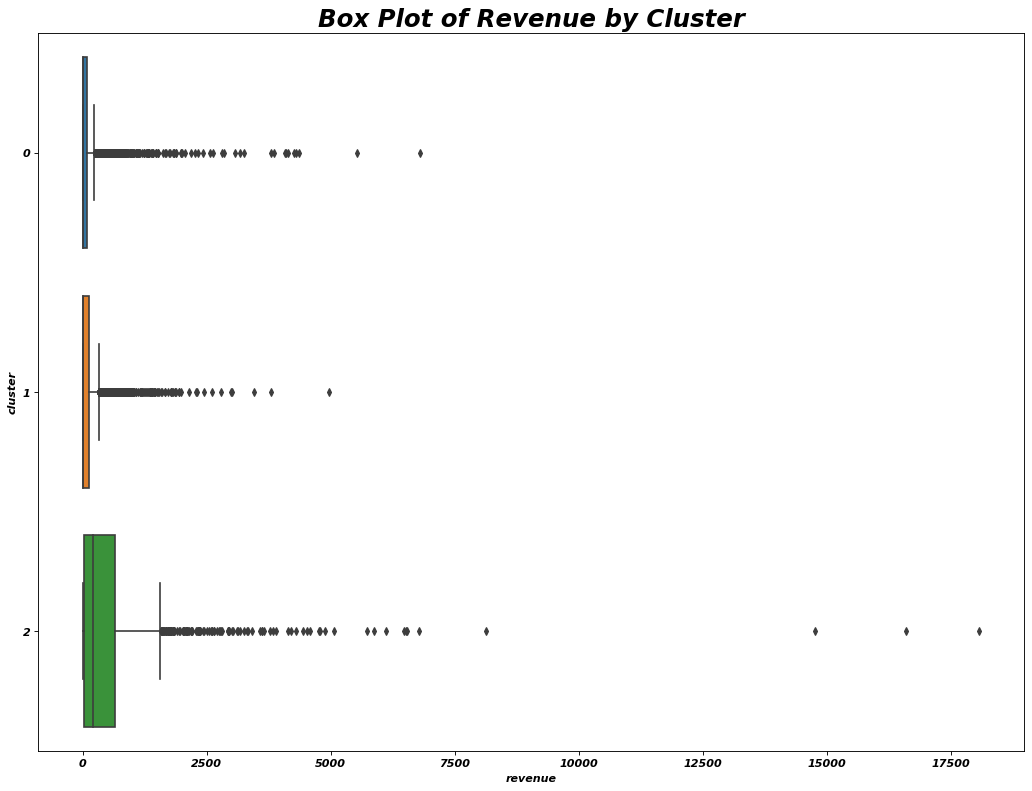

In [44]:
# get data
df0 = df.copy()

# draw plot
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(y='cluster', x='purchase_value', data=df, notch=False, orient='h')

# labels
plt.title('Box Plot of Revenue by Cluster', fontsize=22)
# plt.xlim(0, 2000000)
plt.tight_layout()
plt.xlabel('revenue')
plt.show()

In [45]:
df['surplus'] = df.purchase_value - df.cost

In [46]:
ave_success_surplus = df[df.surplus>0].surplus.mean()

In [47]:
df.surplus.sum() # ETO YUNG GOAL MO! FOCUS!

1366286.9466553063

In [48]:
df.cost.sum()

525298.7604062837

In [49]:
df[df.surplus>0].cost.mean()

53.97531793697401

In [50]:
num_camp_days_success = df.cost.sum() / df[df.surplus>0].cost.mean()

In [51]:
num_camp_days_success

9732.2031714508

In [52]:
new = (ave_success_surplus * num_camp_days_success)

In [53]:
prec = 0.589242

In [54]:
new_final = new * prec - ((1-prec) * df[df.date.dt.year == 2020].cost.sum())

In [55]:
48.5 * (new_final - old)

NameError: name 'old' is not defined

In [ ]:
df[df.surplus>0].cost.median()

In [ ]:
df[df.surplus<0].cost.median()

In [ ]:
df.cost.sum()

In [ ]:
df[df.date.dt.year == 2020].cost.sum()

In [ ]:
df[(df.surplus>0) & (df.date.dt.year == 2020)].cost.median()

In [ ]:
df[(df.date.dt.year == 2020)].cost.count()

In [ ]:
df[(df.surplus>0) & (df.date.dt.year == 2020)].surplus.median()

In [ ]:
old = df[df.date.dt.year == 2020].surplus.sum()

In [ ]:
new * prec - old - (1 - prec) * df[df.date.dt.year == 2020].cost.sum()

In [ ]:
df[df.cluster == 1].cost.median()